In [1]:
import time

import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

from markermap.vae_models import MarkerMap, train_model
from markermap.utils import (
    new_model_metrics,
    plot_confusion_matrix,
    split_data,
    plot_umap_embedding
)

from squidpy_markermap import dataset_squidpy, squidpy_markermap, eval_squidpy

from markermap import vae_models
print(vae_models.__file__)
from markermap import utils
print(utils.__file__)

%load_ext autoreload
%autoreload 2

/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.23.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12
squidpy==1.4.1
scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.23.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12
squidpy==1.4.1
/home/ianubuntu4/COMPUTER/BMCS4480/final/marker_map_spatial/marker_map_spatial/markermap/vae_models.py
/home/ianubuntu4/COMPUTER/BMCS4480/final/marker_map_spatial/marker_map_spatial/markermap/utils.py
/home/ianubuntu4/COMPUTER/BMCS4480/final/marker_map_spatial/marker_map_spatial/markermap/vae_models.py
/home/ianubuntu4/COMPUTER/BMCS4480/final/marker_map_spatial/marker_map_spatial/markermap/utils.py


## Data

In [2]:
adata, train_dataloader, val_dataloader, train_indices, val_indices, test_indices, train_val_indices = dataset_squidpy()

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
(2688, 18078)
(2688,)
['Cortex_1' 'Cortex_2' 'Cortex_3' 'Cortex_4' 'Cortex_5' 'Fiber_tract'
 'Hippocampu

/home/ianubuntu4/COMPUTER/BMCS4480/final/marker_map_spatial/marker_map_spatial/markermap/utils.py:1086: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.utils.data.TensorDataset(torch.Tensor(X), torch.LongTensor(y)),


## Define and train the model

In [3]:
markers = []
params = {
    'z_size': 512,
    'hidden_layer_size': 2048,
    'k': 100,
}

mm = squidpy_markermap(params, adata, train_dataloader, val_dataloader)

{'z_size': 512, 'hidden_layer_size': 2048, 'k': 100}
  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 45.4 M
1 | enc_mean               | Linear     | 1.0 M 
2 | enc_logvar             | Linear     | 1.0 M 
3 | decoder                | Sequential | 38.1 M
4 | dec_logvar             | Sequential | 38.1 M
5 | weight_creator         | Sequential | 78.3 M
6 | classification_decoder | Sequential | 1.1 M 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
203 M     Trainable params
0         Non-trainable params
203 M     Total params
812.302   Total estimated model params size (MB)


/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
Finding best initial lr: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


In [5]:
group_by = 'annotation'
misclass_rate, test_rep, cm, Y_pred = new_model_metrics(
    adata[train_val_indices, :].X,
    adata[train_val_indices, :].obs[group_by],
    adata[test_indices, :].X,
    adata[test_indices, :].obs[group_by],
    markers = mm.markers().clone().cpu().detach().numpy(),
    X = adata.X
)

in new_model_metrics
train_x shape: (2149, 100)
Y_pred shape (2688,)


Misclass_rate_with_marker: 0.1447124304267161
f1-score_with_marker: 0.851023027715871
k = 100


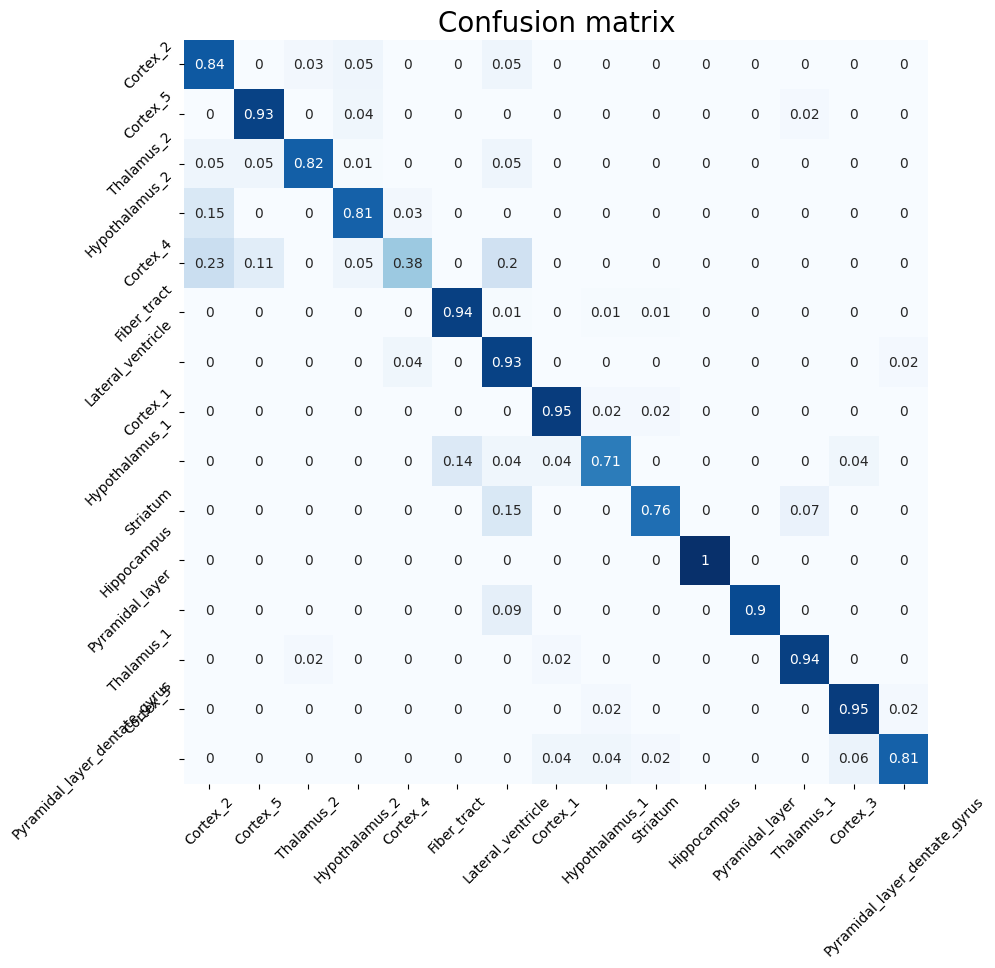

In [7]:
k = 100
print('Misclass_rate_with_marker:', misclass_rate)
print('f1-score_with_marker:', test_rep['weighted avg']['f1-score'])
print('k =', k)
plot_confusion_matrix(cm, adata.obs[group_by].unique())

In [8]:
misclass_rate_no_marker, test_rep_no_marker, cm_no_marker, Y_pred_no_marker = new_model_metrics(
    adata[train_val_indices, :].X,
    adata[train_val_indices, :].obs[group_by],
    adata[test_indices, :].X,
    adata[test_indices, :].obs[group_by],
    X = adata.X
)

in new_model_metrics
train_x shape: (2149, 18078)
Y_pred shape (2688,)


Misclass_rate_with_no_marker: 0.08719851576994431
f1-score with no marker: 0.9103443172432639
Number of genes for training: 18078


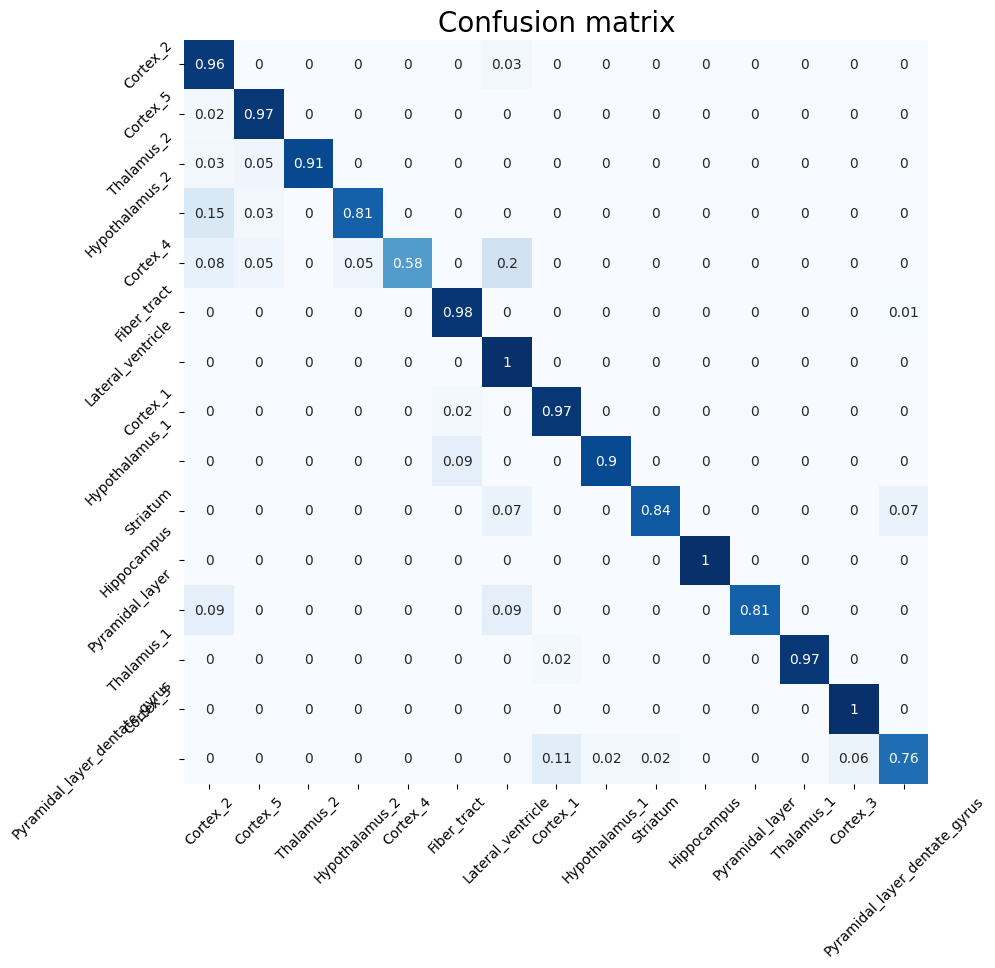

In [9]:
print('Misclass_rate_with_no_marker:', misclass_rate_no_marker)
print('f1-score with no marker:', test_rep_no_marker['weighted avg']['f1-score'])
print('Number of genes for training:', adata.X.shape[1])
plot_confusion_matrix(cm_no_marker, adata.obs[group_by].unique())

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'annotation', 'Y_true', 'Y_pred_marker', 'Y_pred_no_marker'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'i

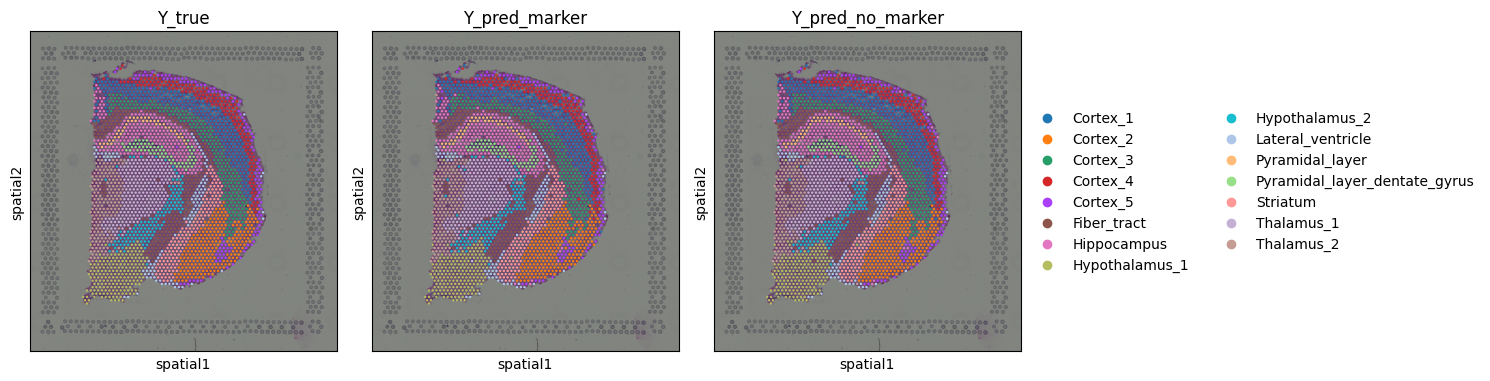

In [10]:
# true
adata_new = adata.copy()
adata_new.obs['Y_true'] = adata_new.obs['cluster']
adata_new.obs['Y_pred_marker'] = Y_pred
adata_new.obs['Y_pred_no_marker'] = Y_pred_no_marker
print(adata_new)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))

sq.pl.spatial_scatter(adata_new, color="Y_true", figsize=(10, 10), ax=ax1, legend_loc=None)
sq.pl.spatial_scatter(adata_new, color="Y_pred_marker", figsize=(10, 10), ax=ax2, legend_loc=None)
sq.pl.spatial_scatter(adata_new, color="Y_pred_no_marker", figsize=(10, 10), ax=ax3)
fig.tight_layout()
fig.savefig('reconstruction.png')

## UMAP

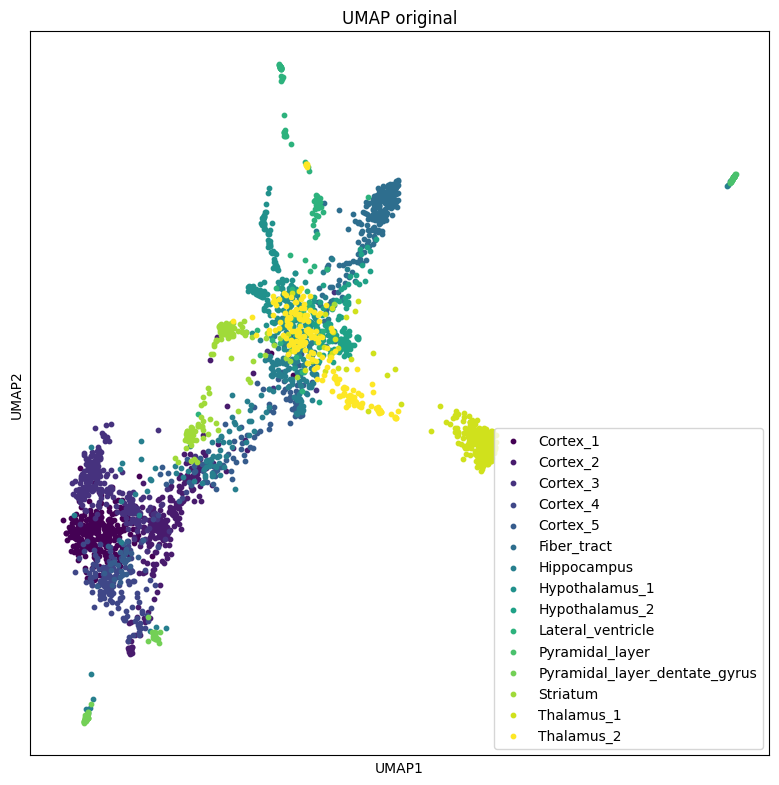

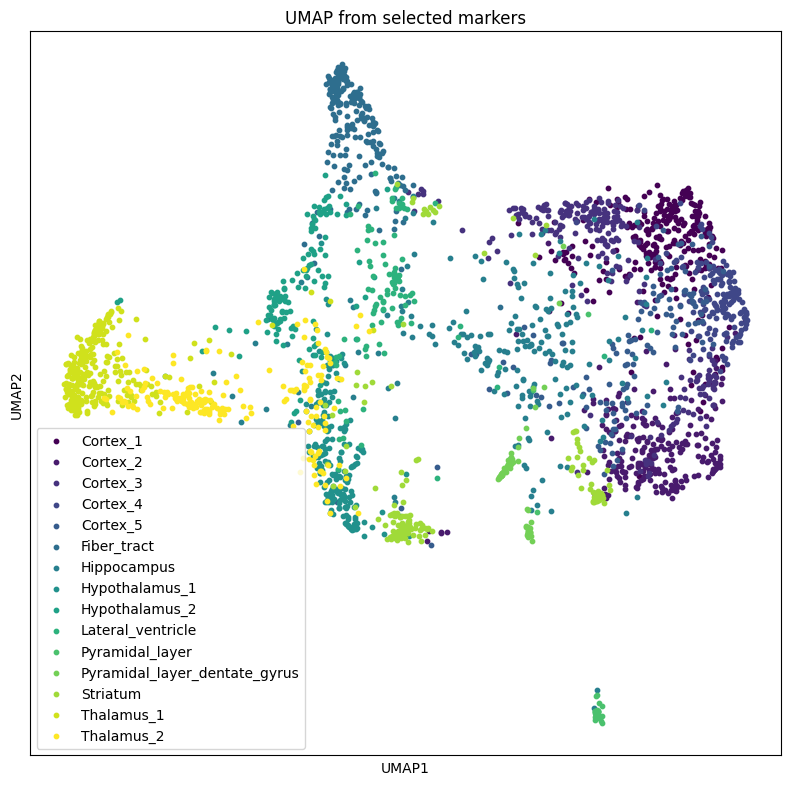

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = np.unique(adata.obs[group_by])

label_encoder.fit(labels)
encoded_labels = label_encoder.transform(labels)

plot_umap_embedding(adata.X, adata.obs[group_by].cat.codes, label_encoder, 'UMAP original')

plot_umap_embedding(
    adata.X,
    adata.obs[group_by].cat.codes,
    label_encoder,
    'UMAP from selected markers',
    markers=mm.markers().clone().cpu().detach().numpy()
)